<a href="https://colab.research.google.com/github/Pengyu-gis/Historical-Aerial-Photos/blob/main/Tif_Colorization/Deoldify_Colorize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Clone the DeOldify repository
!git clone https://github.com/jantic/DeOldify.git
%cd DeOldify

# Install required libraries
!pip install -r requirements-colab.txt
!pip install ffmpeg
!pip install fastai==1.0.61
!pip install rasterio

In [ ]:
!mkdir 'models'
!wget https://data.deepai.org/deoldify/ColorizeArtistic_gen.pth -O ./models/ColorizeArtistic_gen.pth


In [ ]:
!wget https://www.dropbox.com/s/axsd2g85uyixaho/ColorizeStable_gen.pth?dl=0 -O ./models/ColorizeStable_gen.pth

In [ ]:
# Import necessary modules
from deoldify import device
from deoldify.device_id import DeviceId
from deoldify.visualize import get_image_colorizer

# Set up GPU for processing
device.set(device=DeviceId.GPU0)

# Load the image colorizer model
colorizer = get_image_colorizer(artistic=False)


Colorized TIFF saved at: /content/drive/MyDrive/aerial_photos/colored/color_patch_7.tif


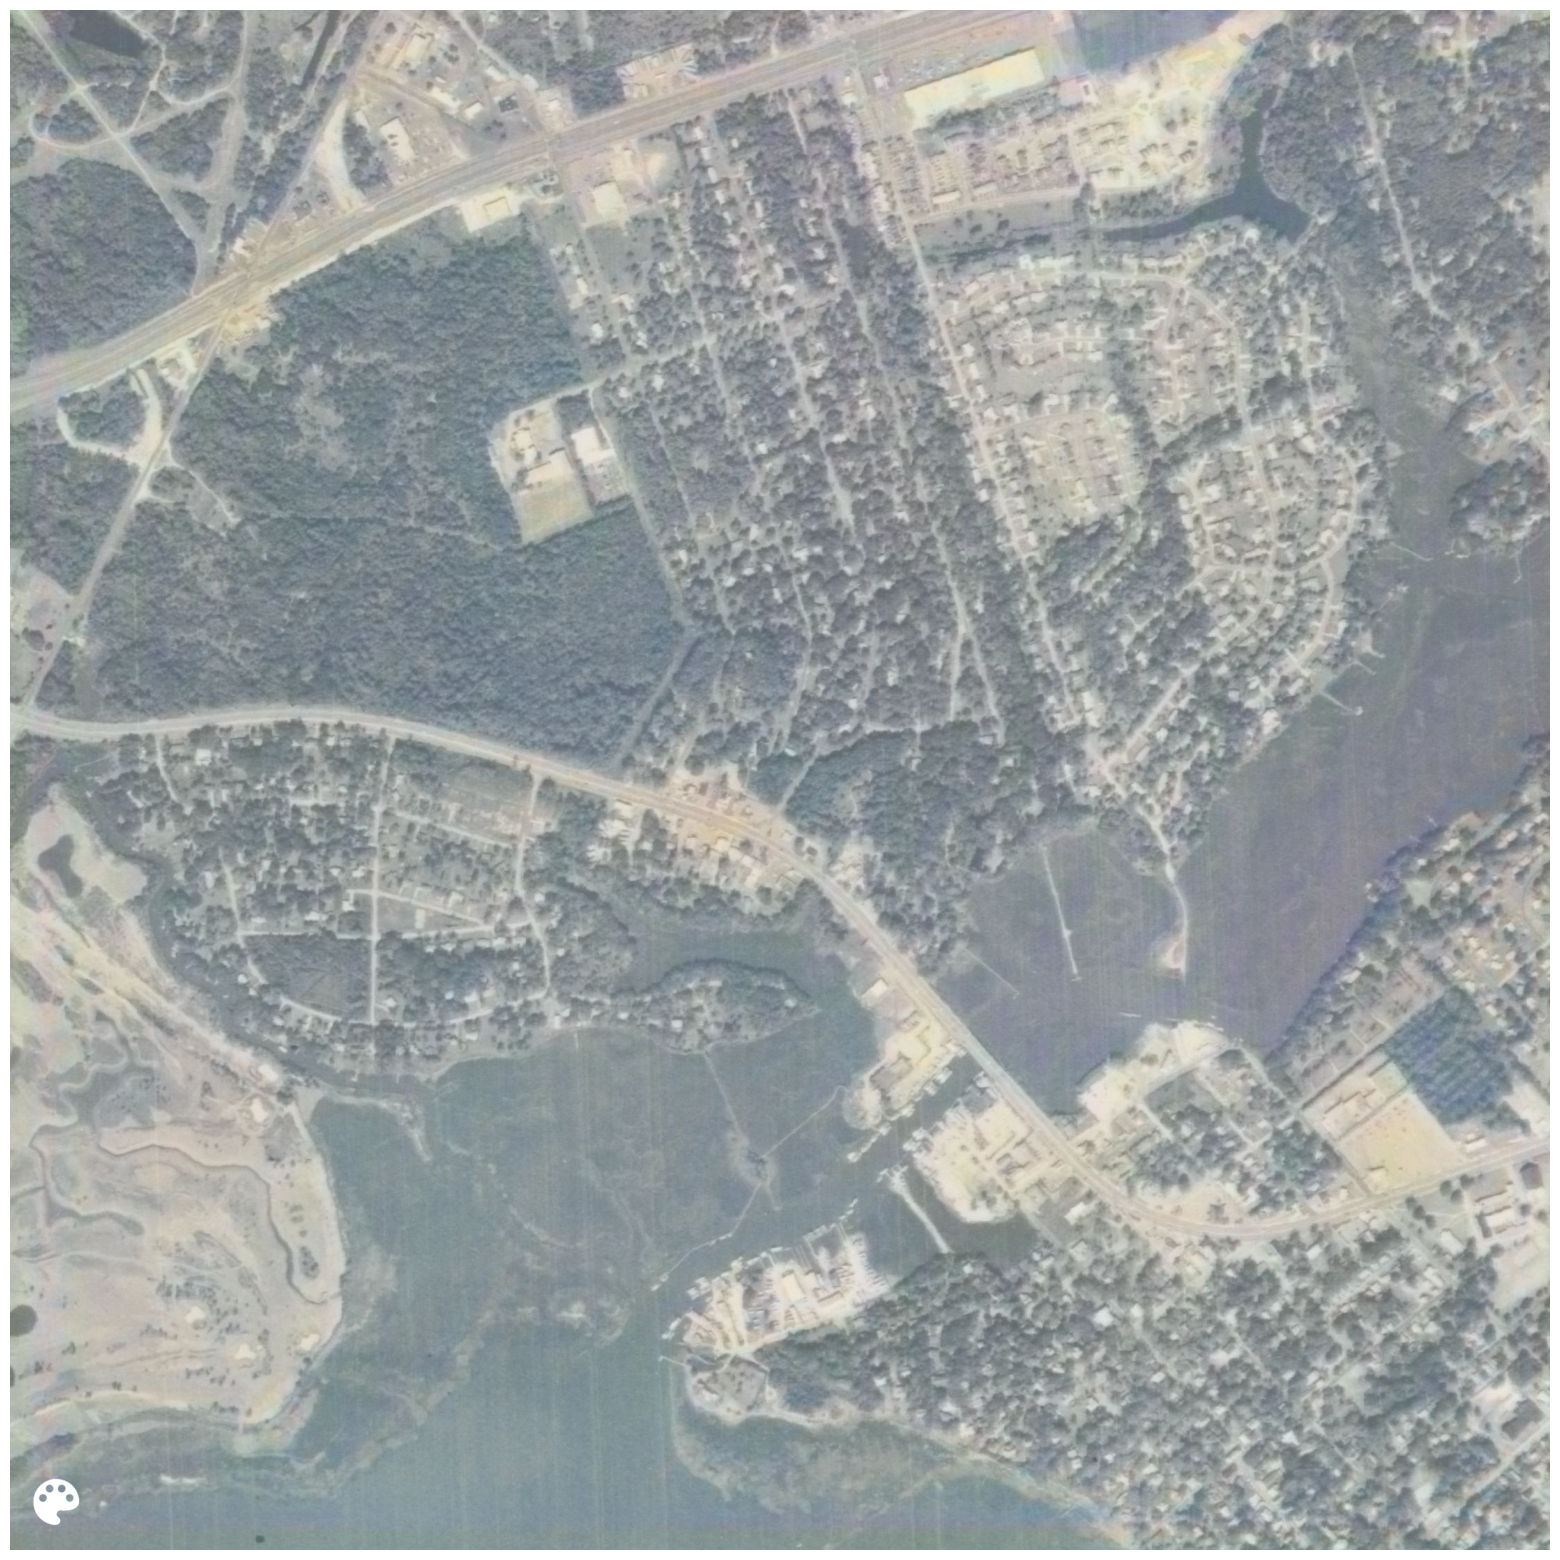

In [ ]:
from PIL import Image
import rasterio
import numpy as np
import os

# Step 1: Convert .tif to .jpg
def tif_to_jpg(input_tif, output_jpg):
    with rasterio.open(input_tif) as src:
        data = src.read(1)  # Read the first band (grayscale)
        transform = src.transform
        crs = src.crs
        # Remove nodata if it exists in metadata
        meta = src.meta.copy()
        if "nodata" in meta:
            del meta["nodata"]

    img = Image.fromarray(data).convert("L")  # Convert to grayscale
    img.save(output_jpg, "JPEG")
    return output_jpg, transform, crs, meta

# Step 2: Convert .jpg back to .tif (with RGB metadata)
def jpg_to_tif(input_jpg, output_tif, original_meta, transform, crs):
    img = Image.open(input_jpg).convert("RGB")  # Ensure the image is RGB
    data = np.array(img)  # Shape: (height, width, 3)

    # Update metadata for RGB
    updated_meta = original_meta.copy()
    updated_meta.update({
        'count': 3,  # Number of bands for RGB
        'dtype': 'uint8',  # Data type for color images
        'transform': transform,
        'crs': crs
    })

    # Write RGB bands
    with rasterio.open(output_tif, "w", **updated_meta) as dst:
        dst.write(data[:, :, 0], 1)  # Red channel
        dst.write(data[:, :, 1], 2)  # Green channel
        dst.write(data[:, :, 2], 3)  # Blue channel

# Example Workflow
input_tif = "/content/drive/MyDrive/aerial_photos/square_patches/patch_7.tif"
output_jpg = "/content/drive/MyDrive/aerial_photos/colored/color_patch_7.jpg"
output_tif = "/content/drive/MyDrive/aerial_photos/colored/color_patch_7.tif"

# Step 1: Convert TIFF to JPEG
jpg_path, transform, crs, original_meta = tif_to_jpg(input_tif, output_jpg)

# Step 2: Use DeOldify to colorize
colorizer = get_image_colorizer(artistic=False)  # Load DeOldify colorizer
result_path = colorizer.plot_transformed_image(path=jpg_path, render_factor=10)

# Ensure the colorized image is saved correctly
if os.path.exists(result_path):
    # Replace jpg_path with the path of the saved colorized image
    jpg_path = result_path
else:
    raise FileNotFoundError(f"Colorized image not found at {result_path}")

# Step 3: Convert back to TIFF with metadata
jpg_to_tif(jpg_path, output_tif, original_meta, transform, crs)

print(f"Colorized TIFF saved at: {output_tif}")


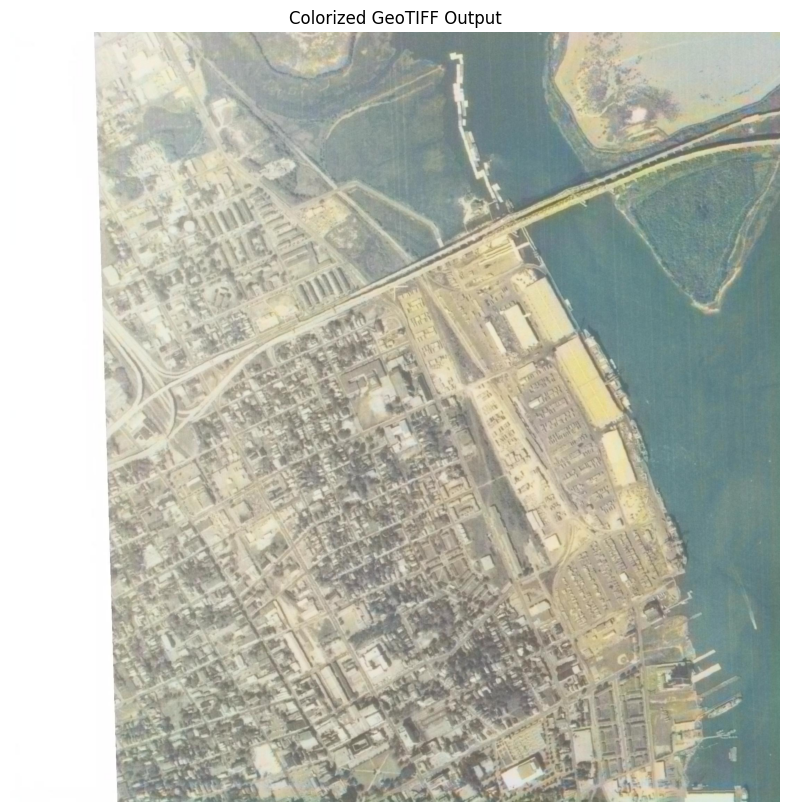

In [ ]:
import rasterio
import matplotlib.pyplot as plt

# Load the GeoTIFF file
tif_path = '/content/drive/MyDrive/aerial_photos/colored/color_patch_5.tif'  # Update to the correct path if necessary

# Open the GeoTIFF file and read the RGB bands
with rasterio.open(tif_path) as src:
    bands = [src.read(i) for i in range(1, src.count + 1)]

# Display the RGB image
rgb_image = None
if len(bands) == 3:  # Ensure it's RGB
    rgb_image = np.stack(bands, axis=-1)
    plt.figure(figsize=(10, 10))
    plt.imshow(rgb_image)
    plt.title("Colorized GeoTIFF Output")
    plt.axis("off")
    plt.show()
else:
    print("The TIFF file does not have 3 bands for RGB.")
